In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import timeit

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [15]:
data = pd.read_csv('covid_impact_on_airport_traffic.csv')
data.Country.value_counts()

United States of America (the)    4441
Canada                            2311
Australia                          257
Chile                              238
Name: Country, dtype: int64

In [18]:
dataset_Canada = data[data['Country']=='Canada']
df_Canada = pd.DataFrame(dataset_Canada.groupby('Date',as_index=True)['PercentOfBaseline'].mean())
df_Canada.head()

,PercentOfBaseline
Date,
2020-03-16,92.333333
2020-03-17,87.888889
2020-03-18,88.000000
2020-03-19,84.777778
2020-03-20,86.666667


In [19]:
#Convert pandas dataframe to numpy array
dataset = df_Canada.values
dataset = dataset.astype('float32') #COnvert values to float

In [20]:
#Normalization is optional but recommended for neural network as certain 
#activation functions are sensitive to magnitude of numbers. 
#normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

In [21]:
#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [23]:
# We cannot fit the model like we normally do for image processing where we have
#X and Y. We need to transform our data into something that looks like X and Y values.
# This way it can be trained on a sequence rather than indvidual datapoints. 
# Let us convert into n number of columns for X where we feed sequence of numbers
#then the final column as Y where we provide the next number in the sequence as output.
# So let us convert an array of values into a dataset matrix

#seq_size is the number of previous time steps to use as 
#input variables to predict the next time period.

#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 10 # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [24]:
#Compare trainX and dataset. You can see that X= values at t, t+1 and t+2
#whereas Y is the value that follows, t+3 (since our sequence size is 3)

print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (161, 10)
Shape of test set: (79, 10)


In [25]:
#Input dimensions are... (N x seq_size)
print('Build deep model...')
# create and fit dense model
model = Sequential()
model.add(Dense(64, input_dim=seq_size, activation='relu')) #12
model.add(Dense(32, activation='relu'))  #8
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
print(model.summary()) 

#for layer in model.layers:
#print(layer.input_shape)

#Model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)
#Menghitung waktu yang diperlukan untuk pemodelan
start = timeit.default_timer()
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)
stop = timeit.default_timer()
lama_eksekusi = stop - start
print("Lama eksekusi: ",lama_eksekusi,"detik")

Build deep model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
6/6 - 1s - loss: 0.1478 - acc: 0.0062 - val_loss: 0.0204 - val_acc: 0.0127 - 907ms/epoch - 151ms/step
Epoch 2/100
6/6 - 0s - loss: 0.0220 - acc: 0.0000e+00 - val_loss: 0.0409 - val_acc: 0.0127 - 36ms/epoch - 6ms/step
Epoch 3/100
6/6 - 0s - loss: 0.0441 - acc: 0.0000e+00 - val_loss

In [26]:
#Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

3/3 [==============================] - 0s 1ms/step


In [27]:
#Estimate model performance
#Since we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])

In [28]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 12.88 RMSE
Test Score: 12.78 RMSE


In [29]:
#Menghitung mean absolute error
mae = mean_absolute_error(trainY_inverse[0], trainPredict[:,0])
print("Mean Absolute Error (MAE): ", mae)

Mean Absolute Error (MAE):  9.168119505856028


In [30]:
#Shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

#Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

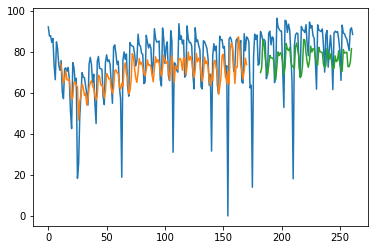

In [31]:
#Plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()